If all samples were actually equally likely, then the sum of $1$s drawn from the population is distributed as hypergeometric with $p = n\times \text{popMean}$ "good" items, $n-p = n*(1-\text{popMean})$ "bad" items, and $k$ draws. This random variable $X$ is distributed with
$$E(X) = k\text{popMean} = \frac{kp}{n}$$
and $$var(X) = \frac{k\text{popMean}(1-\text{popMean})(n-k)}{n-1} = \frac{kp(1-p)(n-k)}{n^2(n-1)}.$$
Instead of the sum, we look at the mean of the $k$ draws, $\bar{X}$. It has a scaled hypergeometric distribution, with
$$E(\bar{X}) = \text{popMean} = \frac{p}{n}$$
and $$var(\bar{X}) = \frac{\text{popMean}(1-\text{popMean})(n-k)}{k(n-1)} = \frac{p(1-p)(n-k)}{kn^2(n-1)}.$$
Finally, we sample from this distribution $B$ times and take the sample average -- this is the column Sample Mean in the table. This is an average of IID random variables, so it has mean $\text{popMean} = \frac{p}{n}$ and variance
$$\frac{\text{popMean}(1-\text{popMean})(n-k)}{Bk(n-1)} = \frac{p(1-p)(n-k)}{Bkn^2(n-1)}.$$

In [14]:
source("simulation_utils.R")
source("test_simulation_utils.R")

makePopulation <- function(n, p){
    # Create a population of 0s and 1s
    # n = pop size
    # p = number of 1s in the population

    x <- rep(0, n)
    x[1:p] <- 1
    return(x)
}
     
                                         
makeAdversarialPopulation <- function(n, indices){
    # Create a population of 0s and 1s
    # n = pop size
    # indices = location of 1s
    x <- rep(0, n)
    x[indices] <- 1
    return(x)
}


makeAdversarialPopulation2 <- function(n, indices){
    # Create a population size n of 0s with one 1 and one -1
    # Put the nonzeros on the provided indices
    x <- rep(0, n)
    for(i in seq_along(indices)){
        x[indices[i]] <- (-1)^i
    }
    return(x)
}

# Super-Duper

In [2]:
# Boilerplate stuff

reps <- 1e4
n <- c(13, 30, 90)
k <- c(4, 10, 20)
p <- c(5, 10, 20)

popMean <- c()
sampleMean <- c()
nvalues <- c()
kvalues <- c()
prng <- c()
seed <- c()
bias <- c()
relBias <- c()
theoreticalSE <- c()

In [3]:
seedvalues = c(100, 233424280)

for(nn in n){
  for(kk in k){
    for(pp in p){
      if(pp >= nn | kk >= nn){
        next
      }
      for(ss in seedvalues){
        set.seed(ss, kind = "Super-Duper")
        
        itemCounts <- getEmpiricalDistrRaw(n=nn, k=kk, reps=reps)
        most_freq_p <- findFreqItems(itemCounts, pp)
         
        x <- makeAdversarialPopulation(nn, most_freq_p)
        #x <- makePopulation(nn, pp)
        truePopMean <- getPopMean(x)
        popMean <- c(popMean, truePopMean)
        obsSampMean <- getSampleMean(x, itemCounts)
        sampleMean <- c(sampleMean, obsSampMean)
        nvalues <- c(nvalues, nn)
        kvalues <- c(kvalues, kk)
        prng <- c(prng, "Super-Duper")
        seed <- c(seed, ss)
        
        estimBias <- obsSampMean - truePopMean
        bias <- c(bias, estimBias)
        relBias <- c(relBias, estimBias/truePopMean)
        
        theoreticalSE <- c(theoreticalSE,
                           sqrt(truePopMean*(1-truePopMean)*(nn-kk)/(reps * kk * (nn-1))))
      }
    }
  }
}

In [4]:
cbind("Pop size" = nvalues, 
      "Sample size" = kvalues, 
      "seed" = seedvalues, 
      "Pop Mean" = popMean, 
      "Sample Mean" = sampleMean, 
      "Bias" = bias, 
      "Relative bias" = relBias, 
      "Theoretical SE" = theoreticalSE,
      "Bias/Theoretical SE" = bias/theoreticalSE 
)

Pop size,Sample size,seed,Pop Mean,Sample Mean,Bias,Relative bias,Theoretical SE,Bias/Theoretical SE
13,4,100,0.38461538,0.390175,0.005559615,0.0144550,0.0021066252,2.639110
13,4,233424280,0.38461538,0.389700,0.005084615,0.0132200,0.0021066252,2.413631
13,4,100,0.76923077,0.774150,0.004919231,0.0063950,0.0018243910,2.696369
13,4,233424280,0.76923077,0.773750,0.004519231,0.0058750,0.0018243910,2.477118
13,10,100,0.38461538,0.386540,0.001924615,0.0050040,0.0007692308,2.502000
13,10,233424280,0.38461538,0.386650,0.002034615,0.0052900,0.0007692308,2.645000
13,10,100,0.76923077,0.770850,0.001619231,0.0021050,0.0006661734,2.430645
13,10,233424280,0.76923077,0.770410,0.001179231,0.0015330,0.0006661734,1.770156
30,4,100,0.16666667,0.172550,0.005883333,0.0353000,0.0017643772,3.334510
30,4,233424280,0.16666667,0.172900,0.006233333,0.0374000,0.0017643772,3.532880


# Mersenne Twister

In [7]:
# Boilerplate stuff

reps <- 1e4
n <- c(13, 30, 90)
k <- c(4, 10, 20)
p <- c(5, 10, 20)

popMean <- c()
sampleMean <- c()
nvalues <- c()
kvalues <- c()
prng <- c()
seed <- c()
bias <- c()
relBias <- c()
theoreticalSE <- c()

In [8]:
seedvalues = c(100, 233424280, 429496729)

for(nn in n){
  for(kk in k){
    for(pp in p){
      if(pp >= nn | kk >= nn){
        next
      }
      for(ss in seedvalues){
        set.seed(ss, kind = "Mersenne-Twister")
        
        itemCounts <- getEmpiricalDistrRaw(n=nn, k=kk, reps=reps)
        most_freq_p <- findFreqItems(itemCounts, pp)
         
        x <- makeAdversarialPopulation(nn, most_freq_p)
        #x <- makePopulation(nn, pp)
        truePopMean <- getPopMean(x)
        popMean <- c(popMean, truePopMean)
        obsSampMean <- getSampleMean(x, itemCounts)
        sampleMean <- c(sampleMean, obsSampMean)
        nvalues <- c(nvalues, nn)
        kvalues <- c(kvalues, kk)
        prng <- c(prng, "Mersenne Twister")
        seed <- c(seed, ss)
        
        estimBias <- obsSampMean - truePopMean
        bias <- c(bias, estimBias)
        relBias <- c(relBias, estimBias/truePopMean)
        
        theoreticalSE <- c(theoreticalSE,
                           sqrt(truePopMean*(1-truePopMean)*(nn-kk)/(reps * kk * (nn-1))))
      }
    }
  }
}

In [9]:
cbind("Pop size" = nvalues, 
      "Sample size" = kvalues, 
      "seed" = seedvalues, 
      "Pop Mean" = popMean, 
      "Sample Mean" = sampleMean, 
      "Bias" = bias, 
      "Relative bias" = relBias, 
      "Theoretical SE" = theoreticalSE,
      "Bias/Theoretical SE" = bias/theoreticalSE 
)

Pop size,Sample size,seed,Pop Mean,Sample Mean,Bias,Relative bias,Theoretical SE,Bias/Theoretical SE
13,4,100,0.3846154,0.390350,0.005734615,0.0149100,0.0021066252,2.722181
13,4,233424280,0.3846154,0.390100,0.005484615,0.0142600,0.0021066252,2.603508
13,4,429496729,0.3846154,0.392025,0.007409615,0.0192650,0.0021066252,3.517292
13,4,100,0.7692308,0.774200,0.004969231,0.0064600,0.0018243910,2.723775
13,4,233424280,0.7692308,0.774450,0.005219231,0.0067850,0.0018243910,2.860807
13,4,429496729,0.7692308,0.773525,0.004294231,0.0055825,0.0018243910,2.353789
13,10,100,0.3846154,0.386230,0.001614615,0.0041980,0.0007692308,2.099000
13,10,233424280,0.3846154,0.386630,0.002014615,0.0052380,0.0007692308,2.619000
13,10,429496729,0.3846154,0.386360,0.001744615,0.0045360,0.0007692308,2.268000
13,10,100,0.7692308,0.770540,0.001309231,0.0017020,0.0006661734,1.965300


# Another simulation - bias in the sample range and sample SD in samples of 2

Suppose we draw a sample of size 2 from a population of size 30. The statistic we're interested in is the range.
We'll use sample() to draw samples using Mersenne Twister, then tally empirical probability of each sample and test for uniformity by using the range of sample frequencies as the test statistic.
A (true) simple random sample of size $k$ from a population of size $n$ has chance $1/{n \choose k}$ of resulting in each of the ${n \choose k}$ possible subsets.
The joint distribution of the number of times each possible sample is selected in $N$ independent random samples is multinomial with ${n \choose k}$ categories, equal category probabilities $1/{n \choose k}$, and $N$ draws.
The pidgeonhold arguments prove that the actual distribution cannot be exactly multinomial, but how bad is the approximation?
We can test the hypothesis using as the test statistic the range of category counts.
Since we can't trust simulations to give an accurate result (that's the problem we are studying!), we need to rely on asymptotics.

In [39]:
n = 30; k = 2; ss <- 1234567903
reps <- 1e7
set.seed(ss, kind = "Mersenne-Twister")
        
samReplicates <- getEmpiricalDistrRaw(n=n, k=k, reps=reps)
samReplicatesList <- getEmpiricalDistr(samReplicates)
least_freq_sample <- findInfrequentSamples(samReplicatesList)
cat("The least frequently sampled pair is ", least_freq_sample$sample,
    ", occurring ", least_freq_sample$freq, "times out of ", reps)

The least frequently sampled pair is  4 10 , occurring  22491 times out of  1e+07

P-value for the range of multinomial counts:  2.058407e-10 
P-value for chi-squared test:  0.1405879

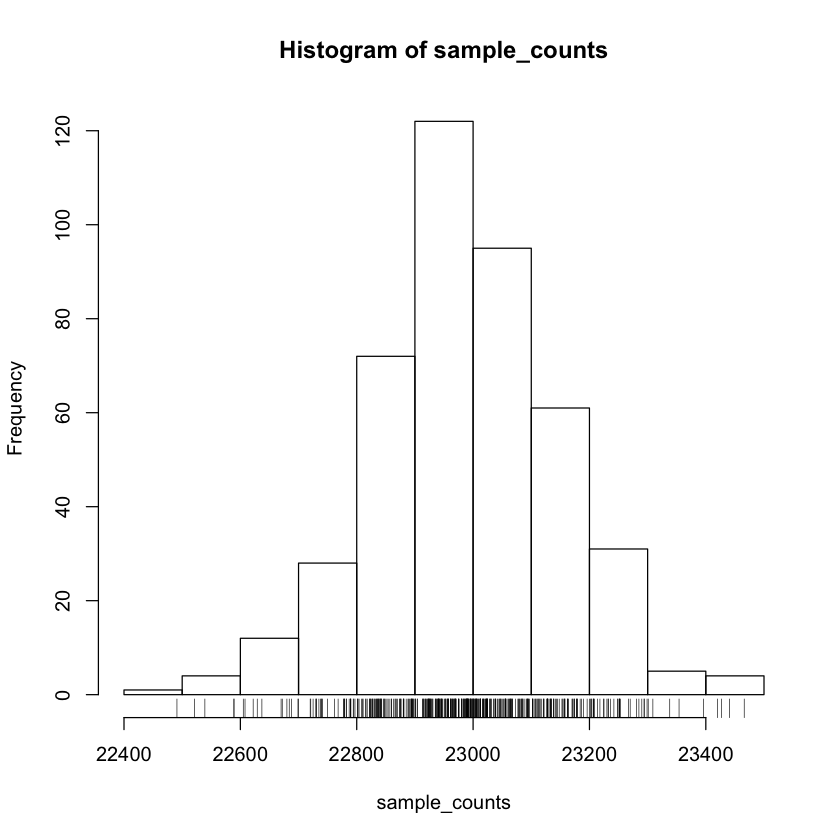

In [47]:
hist(sample_counts); rug(sample_counts)

# Test for whether samples are approximately distributed as multinomial(N, 1/(nCk))
sample_counts <- sapply(samReplicatesList, function(sam) sam$freq)
range_pvalue <- 1 - distrMultinomialRange(diff(range(sample_counts)), n, k)
chisq_pvalue <- chisq.test(sample_counts)
cat("P-value for the range of multinomial counts: ", range_pvalue, "\n")
cat("P-value for chi-squared test: ", chisq_pvalue$p.value)

The p-value for the range of multinomial counts is nearly 0; we reject the null hypothesis that the samples came from a multinomial distribution where each sample had the same probability of being selected.

In [51]:
pop <- makeAdversarialPopulation2(n, least_freq_sample$sample)
pop

[1]  0  0  0 -1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
[26]  0  0  0  0  0

In [48]:
# distribution of range:  
# 2 with probability 1/(30C2)
# 1 with probability 2C1*28C1/(30C2)
# 0 with probability 28C2/(30C2)

ev_range <- (0*choose(n-k, 2) + 1*choose(k, 1)*choose(n-k, 1) + 2*choose(k, 2))/choose(n, k)
cat("Expected value of the range: ", ev_range)
secondmoment_range <- (0*choose(n-k, 2) + 1*choose(k, 1)*choose(n-k, 1) + 4*choose(k, 2))/choose(n, k)
var_range <- secondmoment_range - ev_range^2
cat("\nStd dev of the range: ", sqrt(var_range))
seMeanRange <- sqrt(var_range/reps)
cat("\nStd error of the average range across simulations: ", seMeanRange)

distrSampleRange <- apply(samReplicates, 1, function(row) diff(range(pop[row])))
avgSampleRange <- mean(distrSampleRange)
cat("\nAverage sample range across simulations: ", avgSampleRange)
diff <- avgSampleRange - ev_range
cat("\nDifference between observed and theoretical mean: ", diff)
cat("\nStandardized difference: ", diff/seMeanRange)

Expected value of the range:  0.1333333
Std dev of the range:  0.3466313
Std error of the average range across simulations:  0.0001096144
Average sample range across simulations:  0.1332791
Difference between observed and theoretical mean:  -5.423333e-05
Standardized difference:  -0.4947645

Now, let's look at bias in the sample variance. For $k=2$,
$s^2 = \frac{1}{k-1} \sum_{j=1}^k (x_j - \bar{x})^2 = (x_1 - \bar{x})^2 + (x_2 - \bar{x})^2$.

In [50]:
# distribution of sample variance:  
# 
# (1-0)^2 + (-1-0)^2 = 2  with probability 1/(30C2)
# 2*(1/2)^2 = 1/2 with probability 2C1*28C1/(30C2)
# 0 with probability 28C2/(30C2)

ev_sv <- (0*choose(n-k, 2) + 0.5*choose(k, 1)*choose(n-k, 1) + 2*choose(k, 2))/choose(n, k)
cat("Expected value of the sample variance: ", ev_sv)
secondmoment_sv <- (0*choose(n-k, 2) + 0.25*choose(k, 1)*choose(n-k, 1) + 4*choose(k, 2))/choose(n, k)
var_sv <- secondmoment_sv - ev_sv^2
cat("\nStd dev of the sample variance: ", sqrt(var_sv))
seMeanSV <- sqrt(var_sv/reps)
cat("\nStd error of the average sample variance across simulations: ", seMeanSV)

distrSV <- apply(samReplicates, 1, function(row) var(pop[row]))
avgSV <- mean(distrSV)
cat("\nAverage sample variance across simulations: ", avgSV)
diff <- avgSV - ev_sv
cat("\nDifference between observed and theoretical mean: ", diff)
cat("\nStandardized difference: ", diff/seMeanSV)

Expected value of the sample variance:  0.06896552
Std dev of the sample variance:  0.1913715
Std error of the average sample variance across simulations:  6.0517e-05
Average sample variance across simulations:  0.06888865
Difference between observed and theoretical mean:  -7.686724e-05
Standardized difference:  -1.270176